In [67]:
library(GenomicRanges)
library(ggplot2)

In [ ]:
# Import NOMe-seq signal. Note that this data is hg19
NOMe_bigwig_path <- "/home/yanhu/data/DddA/SMF_benchmark/Helbo_et_al_NOMe_seq/GSM1583567_K562_400_merge_C33YCACXX_C3JK7ACXX_C4JVWACXX_KEL656A315_GCH.hg19_rCRSchrm.fa.realign.mdups.recal.cytosine.filtered.sort.GCH.bw"
NOMe_bigwig <- rtracklayer::import.bw(NOMe_bigwig_path) 
NOMe_bigwig$score <- NOMe_bigwig$score / 100
# I checked that min NOMe signal is 0, meaning that cytosines covered but not methylated are recorded

In [3]:
# Import DddA edit track
DddA_edit_path <- "/home/yanhu/data/DddA/HJR253/HJR253_4_edit.bw"
DddA_edits <- rtracklayer::import.bw(DddA_edit_path)

# Import DddA coverage track
DddA_coverage_path <- "/home/yanhu/data/DddA/HJR253/HJR253_4_coverage.bw"
DddA_coverages <- rtracklayer::import.bw(DddA_coverage_path) # I checked that min coverage is 1

# Calculate edit rate
DddA_edits$edit_rate <- DddA_edits$score / DddA_coverages$score

In [8]:
# Load ATAC-seq peaks
# ENCODE narrowPeak format info here https://genome.ucsc.edu/FAQ/FAQformat.html#format12
ATAC_peak_path <- "/home/yanhu/data/DddA/SMF_benchmark/Helbo_et_al_NOMe_seq/ENCFF333TAT.bed"
extraCols <- c(
  signalValue = "numeric",  
  pValue = "numeric",       
  qValue = "numeric",      
  peak = "numeric"          
)
ATAC_peaks <- rtracklayer::import(ATAC_peak_path, format="bed", extraCols = extraCols)

In [53]:
# Load chain file for liftOver
pathToChain <- "/home/yanhu/data/DddA/SMF_benchmark/Helbo_et_al_NOMe_seq/hg19ToHg38.over.chain"
ch <- rtracklayer::import.chain(pathToChain)

# Lift over from hg19 to hg38
seqlevelsStyle(ATAC_peaks) <- "UCSC"  # necessary
NOMe_bigwig_hg38 <- unlist(rtracklayer::liftOver(NOMe_bigwig, ch))

In [ ]:
# Load chain file for liftOver
pathToChain <- "/home/yanhu/data/DddA/SMF_benchmark/Helbo_et_al_NOMe_seq/hg19ToHg38.over.chain"
ch <- rtracklayer::import.chain(pathToChain)

# Lift over from hg19 to hg38
seqlevelsStyle(ATAC_peaks) <- "UCSC"  # necessary
ATAC_peaks_hg19 <- unlist(rtracklayer::liftOver(ATAC_peaks, ch))

In [43]:
NOMe_signal_filt <- subsetByOverlaps(NOMe_bigwig, ATAC_peaks_hg19)

In [63]:
DddA_edits_filt <- subsetByOverlaps(DddA_edits, ATAC_peaks)
NOMe_signal_filt_hg38 <- subsetByOverlaps(NOMe_bigwig_hg38, ATAC_peaks)

In [233]:
sum(DddA_edits$edit_rate > 0)

[1] 149003767

pdf 
  2

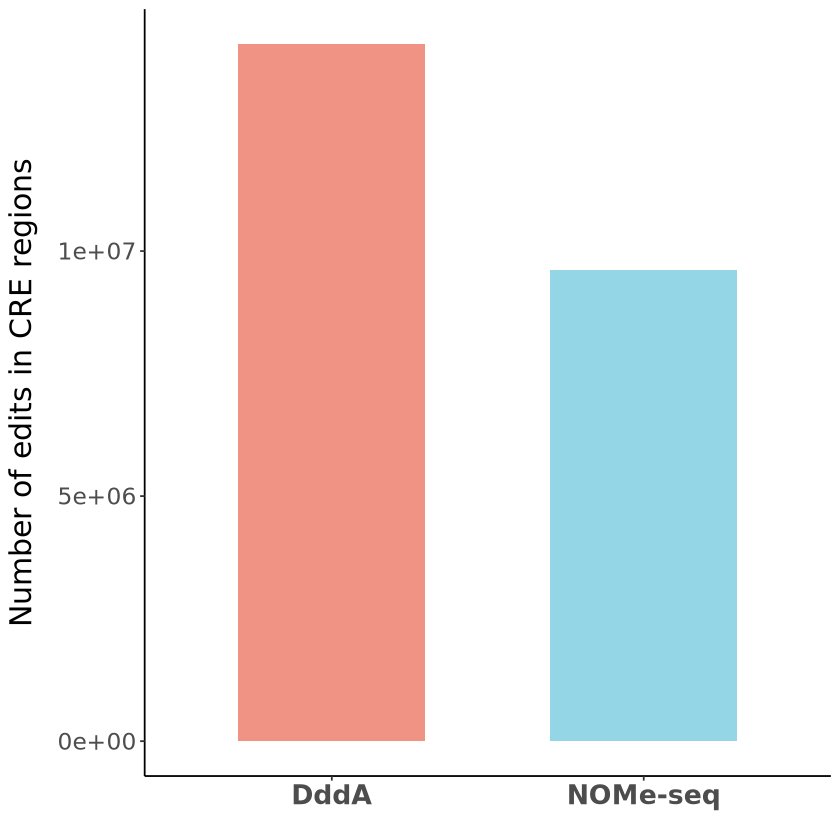

In [104]:
threshold <- 0.05
DddA_CRE_editable_n <- sum(DddA_edits_filt$edit_rate > threshold)
NOMe_CRE_editable_n <- sum(NOMe_signal_filt_hg38$score > threshold)
data <- data.frame(
  method = c("NOMe-seq", "DddA"),
  n_edit_pos = c(NOMe_CRE_editable_n, DddA_CRE_editable_n)
)

# Create the bar plot
p <- ggplot(data, aes(x = method, y = n_edit_pos, fill = method)) +
  geom_bar(stat = "identity", width = 0.6) +
  labs(x = "",
       y = "Number of edits in CRE regions") +
  theme_classic() +
  scale_fill_manual(values = c("#E64B3599", "#4DBBD599")) +
  theme(
      axis.text.x = element_text(size = 16, face = "bold"),  # X-axis text
      axis.text.y = element_text(size = 14),                 # Y-axis text
      axis.title.y = element_text(size = 18),                # Y-axis title
      plot.title = element_text(size = 22, hjust = 0.5),     # Centered title
      ) +
  theme(axis.title.y = element_text(margin = margin(r = 20))) +
  theme(legend.position = "none")

pdf(paste0("/home/yanhu/data/DddA/SMF_benchmark/Helbo_et_al_NOMe_seq/plots/barplot_CRE_editable_n_threshold_", threshold, ".pdf"))
p
dev.off()
p

pdf 
  2

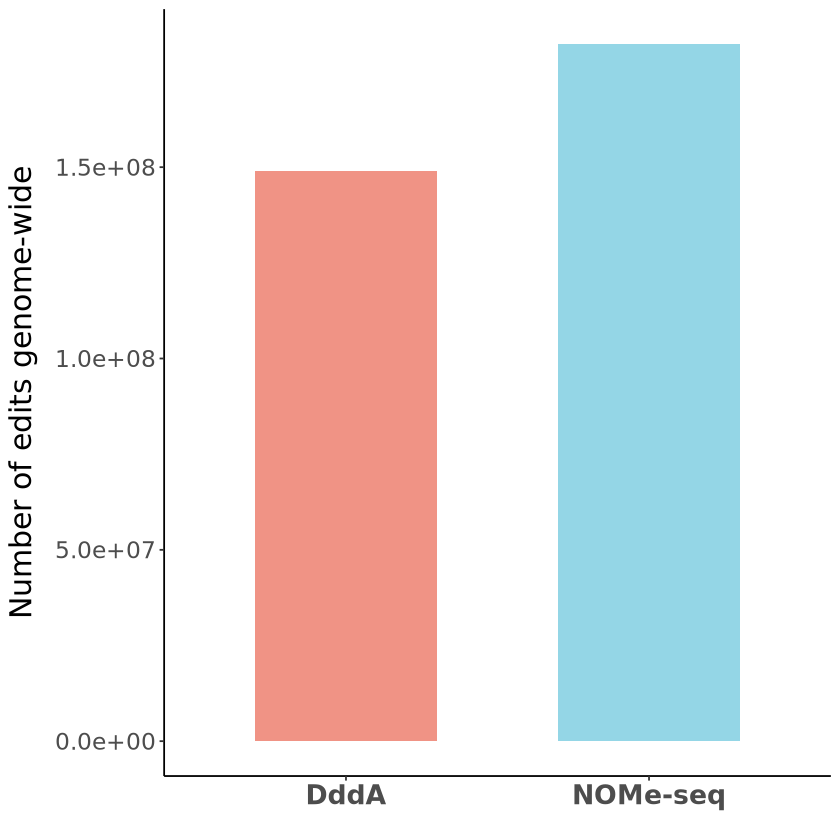

In [106]:
threshold <- 0
NOMe_editable_n <- sum(NOMe_bigwig_hg38$score > threshold)
DddA_editable_n <- sum(DddA_edits$edit_rate > threshold)
data <- data.frame(
  method = c("NOMe-seq", "DddA"),
  n_edit_pos = c(NOMe_editable_n, DddA_editable_n)
)

# Create the bar plot
p <- ggplot(data, aes(x = method, y = n_edit_pos, fill = method)) +
  geom_bar(stat = "identity", width = 0.6) +
  labs(x = "",
       y = "Number of edits genome-wide") +
  theme_classic() +
  scale_fill_manual(values = c("#E64B3599", "#4DBBD599")) +
  theme(
      axis.text.x = element_text(size = 16, face = "bold"),  # X-axis text
      axis.text.y = element_text(size = 14),                 # Y-axis text
      axis.title.y = element_text(size = 18),                # Y-axis title
      plot.title = element_text(size = 22, hjust = 0.5),     # Centered title
      ) +
  theme(axis.title.y = element_text(margin = margin(r = 20))) +
  theme(legend.position = "none")

pdf(paste0("/home/yanhu/data/DddA/SMF_benchmark/Helbo_et_al_NOMe_seq/plots/barplot_editable_n_threshold_", threshold, ".pdf"))
p
dev.off()
p

In [231]:
DddA_editable_n

[1] 149003767

In [113]:
sum(NOMe_signal_filt_hg38$score) / sum(NOMe_bigwig_hg38$score)

[1] 0.067085

In [109]:
sum(DddA_edits_filt$score) / sum(DddA_edits$score)

[1] 0.1324953

pdf 
  2

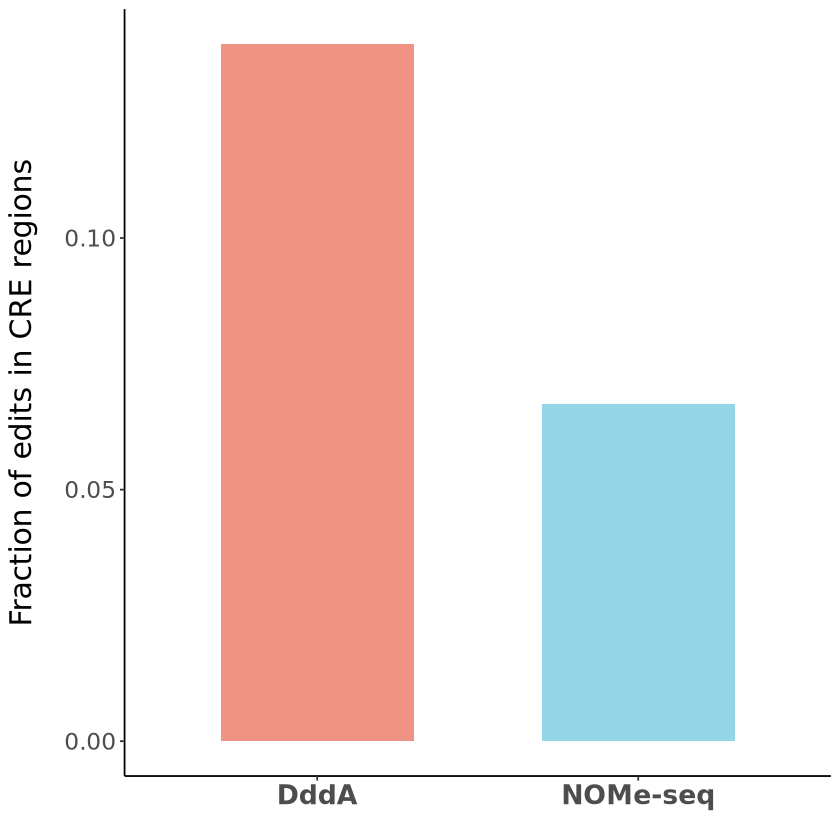

In [118]:
NOMe_enrichment <- sum(NOMe_signal_filt_hg38$score) / sum(NOMe_bigwig_hg38$score)
DddA_enrichment <- sum(DddA_edits_filt$edit_rate) / sum(DddA_edits$edit_rate)
data <- data.frame(
  method = c("NOMe-seq", "DddA"),
  fraction_in_peaks = c(NOMe_enrichment, DddA_enrichment)
)

# Create the bar plot
p <- ggplot(data, aes(x = method, y = fraction_in_peaks, fill = method)) +
  geom_bar(stat = "identity", width = 0.6) +
  labs(x = "",
       y = "Fraction of edits in CRE regions") +
  theme_classic() +
  scale_fill_manual(values = c("#E64B3599", "#4DBBD599")) +
  theme(
      axis.text.x = element_text(size = 16, face = "bold"),  # X-axis text
      axis.text.y = element_text(size = 14),                 # Y-axis text
      axis.title.y = element_text(size = 18),                # Y-axis title
      plot.title = element_text(size = 22, hjust = 0.5),     # Centered title
      ) +
  theme(axis.title.y = element_text(margin = margin(r = 20))) +
  theme(legend.position = "none")

pdf("/home/yanhu/data/DddA/SMF_benchmark/Helbo_et_al_NOMe_seq/plots/barplot_CRE_enrichment.pdf")
p
dev.off()
p